In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups # 20 kategori var
from sklearn.preprocessing import LabelEncoder #etiketleri sayısal formata çevirir
from sklearn.model_selection import train_test_split # veriyi eğitim ve test diye ayırır

from tensorflow.keras.preprocessing.text import Tokenizer # metin verisini sayılara çevirir
from tensorflow.keras.preprocessing.sequence import pad_sequences #dizileri anı uzunluğa getirir
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential

In [13]:
newsgroups = fetch_20newsgroups(subset='all') # all ile hem eğitim hem de test verilerini yükledik
X = newsgroups.data #x = metinler
y = newsgroups.target #y = metinlere karşılık gelen etiketler

In [14]:
# metin verisini tokenize etme ve padding
tokenizer = Tokenizer(num_words=10000) # num_words = en cok kullanılan kelime sayısı
tokenizer.fit_on_texts(X) # tokenizer'ı metin verisi ile fit edelim
X_sequences = tokenizer.texts_to_sequences(X) # metinleri sayısala dönüştürdü
X_padded = pad_sequences(X_sequences,maxlen=100) # metinleri aynı uzunluğa getirdi

In [15]:
# etiketleri sayısal hale dönüştürür (label encoding)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [16]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(
    X_padded,y_encoded,test_size=0.2,random_state=42)

In [21]:
def build_lstm_model():
  model = Sequential()
  # katmanlar: embedding + lstm + dropout + output

  #input_dim: kelime vektörlerinin toplam boyutu
  #output_dim: kelime vektürlerinin boyutu
  #input_length: ehr giriş metninin uzunluğu
  model.add(Embedding(input_dim=10000, output_dim=64, input_shape=(100,)))  # Giriş şekli (100 token)

  # lstm katmanı
  # return_sequence: sonuçların tüm adımları yerine sadece son adımda return etmesi
  model.add(LSTM(units=64,return_sequences=False)) # 64 aded hücre

  # dropout
  model.add(Dropout(0.5))

  # dense katmanı
  model.add(Dense(units=20,activation='softmax'))

  # model compile
  model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [22]:
# model oluşturma
model = build_lstm_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 64)             │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 674,324 (2.57 MB)

 Trainable params: 674,324 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# callvacks = early stop
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,restore_best_weights=True)

In [27]:
# model training
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    batch_size=64,
    epochs=5,
    callbacks=[early_stopping])

Epoch 1/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.7681 - loss: 0.7572 - val_accuracy: 0.6520 - val_loss: 1.1544
Epoch 2/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 44s 113ms/step - accuracy: 0.8202 - loss: 0.6197 - val_accuracy: 0.6737 - val_loss: 1.1531
Epoch 3/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 37s 97ms/step - accuracy: 0.8342 - loss: 0.5789 - val_accuracy: 0.6897 - val_loss: 1.0879
Epoch 4/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 45s 112ms/step - accuracy: 0.8921 - loss: 0.4051 - val_accuracy: 0.6942 - val_loss: 1.1998
Epoch 5/5
236/236 ━━━━━━━━━━━━━━━━━━━━ 37s 96ms/step - accuracy: 0.9010 - loss: 0.3636 - val_accuracy: 0.7191 - val_loss: 1.0866


In [28]:
# test veri seti ile deperlendirme
loss,accuracy = model.evaluate(X_test,y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}%")

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7110 - loss: 1.1522
Test Loss: 1.0866
Test Accuracy: 0.7191%


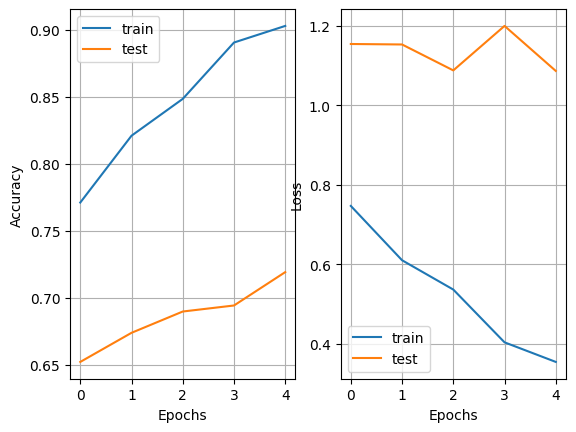

In [29]:
# history kullanarak accuracy ve loss değerlerini görselleştirme
plt.subplot(1,2,1)
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid("True")

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid("True")

plt.show()

----

In [46]:
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    # y_pred'i sınıf indekslerine dönüştür (örneğin [0.1, 0.9] → 1)
    y_pred_classes = K.argmax(y_pred, axis=-1)  # En yüksek olasılıklı sınıfı seç

    # y_true'yu one-hot encode'dan integer'a çevir (sparse etiketler için)
    y_true = K.cast(y_true, 'int64')  # y_true zaten integer

    # Confusion matrix bileşenleri
    tp = K.sum(K.cast(y_true == y_pred_classes, 'float'))  # True Positive
    fp = K.sum(K.cast(y_pred_classes != y_true, 'float'))  # False Positive
    fn = K.sum(K.cast(y_true != y_pred_classes, 'float'))  # False Negative

    # Precision ve Recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # F1-Skor
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return f1

In [47]:
def build_lstm_model():
  model = Sequential()
  # katmanlar: embedding + lstm + dropout + output

  #input_dim: kelime vektörlerinin toplam boyutu
  #output_dim: kelime vektürlerinin boyutu
  #input_length: ehr giriş metninin uzunluğu
  model.add(Embedding(input_dim=10000, output_dim=64, input_shape=(100,)))  # Giriş şekli (100 token)

  # lstm katmanı
  # return_sequence: sonuçların tüm adımları yerine sadece son adımda return etmesi
  model.add(LSTM(units=64,return_sequences=False)) # 64 aded hücre

  # dropout
  model.add(Dropout(0.5))

  # dense katmanı
  model.add(Dense(units=20,activation='softmax'))

  # model compile
  model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Sparse etiketlerle kullanmaya devam et
    metrics=['accuracy', f1_score]  # Düzenlenmiş F1-Skor metriği
)
  return model

In [ ]:
# model training
history = model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    batch_size=64,
    epochs=5,
    callbacks=[early_stopping])